Steps towards writing a custom CNN classifier for image classification in Pytorch:
1. Downloading the data and visuzlizing it (8189 images of 102 flower species):
  * data: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
  * labels: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
2. Writing hyperparameters, device.
3. Writing dataset class, defining dataset and dataloader.
4. Visualizing the data after dataset transformation.
5. Writing the model (+ testing).
6. Writing model, optimizer, loss function.
7. Adding Check accuracy function and implementing to the training.
8. Writing the training loop and training the model.
9. Visualizing model predictions.



In [1]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

STEP-1. Downloading the data and visualizing it (8189 images of 102 flower species):

In [2]:
# Setup training data
train_data = datasets.Flowers102(
    root="data", # location of folder where data is downloaded?
    split="train", # specifing it is training data.
    download=True, # download data if it is not pre downloaded.
    transform=torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)),transforms.RandomHorizontalFlip(),
                                              transforms.RandomRotation(10),ToTensor()]), # transforming images of PIL format into Pytorch Tensors.
    target_transform=None
)

# Setup testing data
test_data = datasets.Flowers102(
    root="data",
    split="test", # specifying it is test data.
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)),ToTensor()])
)

100%|██████████| 345M/345M [00:09<00:00, 34.7MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 446kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 9.49MB/s]


,image_path,image_label
0,/content/data/flowers-102/jpg/image_00001.jpg,76
1,/content/data/flowers-102/jpg/image_00002.jpg,76
2,/content/data/flowers-102/jpg/image_00003.jpg,76
3,/content/data/flowers-102/jpg/image_00004.jpg,76
4,/content/data/flowers-102/jpg/image_00005.jpg,76
...,...,...
8184,/content/data/flowers-102/jpg/image_08185.jpg,61
8185,/content/data/flowers-102/jpg/image_08186.jpg,61
8186,/content/data/flowers-102/jpg/image_08187.jpg,61
8187,/content/data/flowers-102/jpg/image_08188.jpg,61


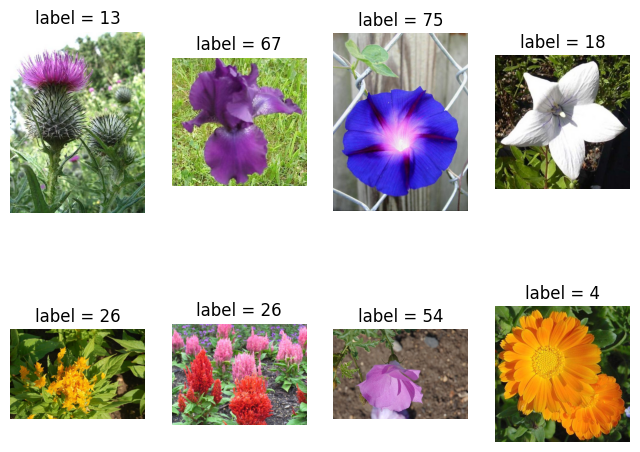

In [3]:
data_path = '/content/data/flowers-102/jpg' #path of images
label_path = '/content/data/flowers-102/imagelabels.mat' #path of img_labels
idpath='/content/data/flowers-102/setid.mat'
label_arr = scp.loadmat(label_path)['labels']
label_arr -= 1
id_arr=scp.loadmat(idpath)
trnid_arr=scp.loadmat(idpath)['trnid']
val_id_arr=scp.loadmat(idpath)['valid']
tstid_arr=scp.loadmat(idpath)['tstid']

#sorted(os.listdir(data_path))[0]
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,6))
image_num = random.sample(range(1,8190), 8)
for i in range(2):
  for j in range(4):
    image = skio.imread(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg'))
    ax[i,j].imshow(image)
    ax[i,j].axis('off')
    ax[i,j].set_title(f'label = {label_arr[0,image_num[i*4+j]]}')

# data frame: index: 8189; columns: 'path', 'label'
labels_list = list(label_arr[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
metadata = pd.DataFrame(
    {'image_path': image_path_list,
     'image_label': labels_list}
)
metadata

In [4]:
label_arr.shape

(1, 8189)

In [5]:
id_arr

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [6]:
trnid_arr[0],val_id_arr[0],tstid_arr[0]

(array([6765, 6755, 6768, ..., 8026, 8036, 8041], dtype=uint16),
 array([6773, 6767, 6739, ..., 8028, 8008, 8030], dtype=uint16),
 array([6734, 6735, 6737, ..., 8044, 8045, 8047], dtype=uint16))

STEP-2. Writing hyperparameters,device.

In [8]:
# Hyperparameters
NUM_OUT_CH = [16,32,64]
IMAGE_W = 100
IMAGE_H = 100
BATCH_SIZE = 32
NUM_EPOCHS = 15
LR = 0.001

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


STEP-3. Writing the dataset class and defining the dataset and the dataloader.

In [9]:
from torchvision import transforms
from sklearn.model_selection import train_test_split

class MyFlowerDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Load image
        image_path = self.metadata.iloc[idx, 0]
        image = skio.imread(image_path)

        # Converting grayscale to RGB according to need.
        if len(image.shape) == 2:  # Grayscale image
            image = np.stack([image] * 3, axis=-1)

        label = int(self.metadata.iloc[idx, 1])
        # Apply transformations that are defined.
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
flower_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Initialize dataset
dataset = MyFlowerDataset(metadata, transform=flower_transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# Define data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

STEP-4. Visualizing the data after dataset transformation.

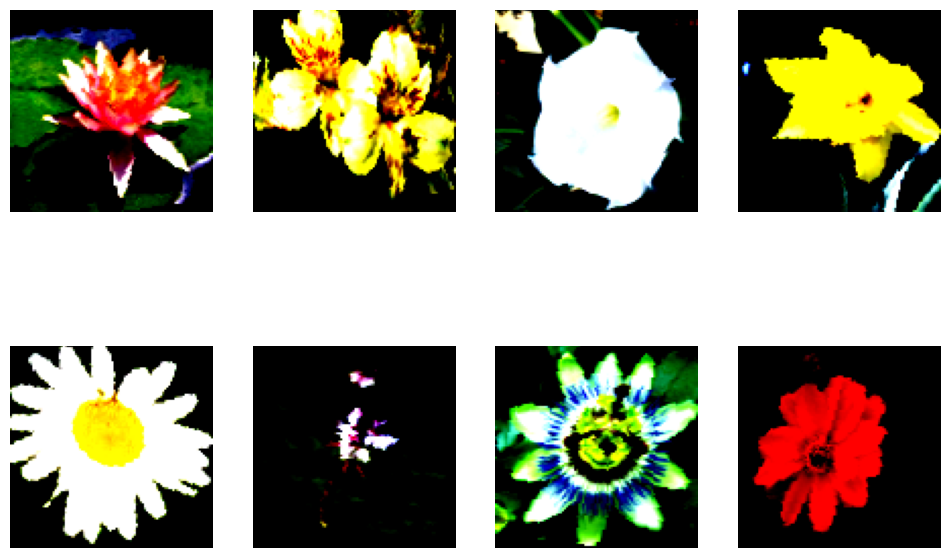

In [10]:
for x,y in train_loader:
  x = x.to(device)
  fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
  for i in range(2):
    for j in range(4):
      ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
      ax[i,j].axis('off')
  break

STEP-5. Writing the model.

In [11]:
import torchvision.models as models
class MyCNN(nn.Module):
  def __init__(self, num_channels=3, num_out_ch=[8,16,32], img_w=100, img_h=100, num_classes=102):
    super(MyCNN, self).__init__()

    self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channels,out_channels=num_out_ch[0],kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_out_ch[0]),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_out_ch[0],out_channels=num_out_ch[0],kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_out_ch[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
    self.block2 = nn.Sequential(
            nn.Conv2d(num_out_ch[0], num_out_ch[0], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[0]),
            nn.ReLU(),
            nn.Conv2d(num_out_ch[0], num_out_ch[0], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[0]),
            nn.ReLU(),
            nn.MaxPool2d(2))
    self.block3 = nn.Sequential(
            nn.Conv2d(num_out_ch[0], num_out_ch[1], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[1]),
            nn.ReLU(),
            nn.Conv2d(num_out_ch[1], num_out_ch[1], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[1]),
            nn.ReLU(),
            nn.MaxPool2d(2))
    self.block4 = nn.Sequential(
            nn.Conv2d(num_out_ch[1], num_out_ch[1], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[1]),
            nn.ReLU(),
            nn.Conv2d(num_out_ch[1], num_out_ch[1], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[1]),
            nn.ReLU(),
            nn.MaxPool2d(2))
    self.block5 = nn.Sequential(
            nn.Conv2d(num_out_ch[1], num_out_ch[2], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[2]),
            nn.ReLU(),
            nn.Conv2d(num_out_ch[2], num_out_ch[2], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[2]),
            nn.ReLU(),
            nn.MaxPool2d(2))
    self.block6 = nn.Sequential(
            nn.Conv2d(num_out_ch[2], num_out_ch[2], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[2]),
            nn.ReLU(),
            nn.Conv2d(num_out_ch[2], num_out_ch[2], 3, padding=1),
            nn.BatchNorm2d(num_out_ch[2]),
            nn.ReLU(),
            nn.MaxPool2d(2))
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=num_out_ch[2]*int(img_w/64)*int(img_h/64),
                      out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes))

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.classifier(x)
    # print(x.shape)
    return x

model = MyCNN()
x = torch.randn(32, 3, 100, 100)
y = model(x)
print(y.shape)

torch.Size([32, 102])


In [12]:
x.reshape(x.shape[0], -1).shape

torch.Size([32, 30000])


STEP-6. Writing model, optimizer, loss function.

In [13]:
model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH, img_w=IMAGE_W, img_h=IMAGE_H, num_classes=102)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = LR)

# Loss Function
criterion = nn.CrossEntropyLoss()

STEP-7. Adding the check accuracy function and model evaluation function for training and testing.


In [14]:
def check_accuracy(loader, model):
  num_corrects = 0
  num_samples = 0
  model.eval()

  with torch.inference_mode():
    for x,y in loader:
      # sending the data to the device
      x = x.to(device)
      y = y.to(device)

      # preparing the data for the model
      # forward pass
      y_hat = model(x)

      # calculating the accuracy
      _, predictions = y_hat.max(1)
      num_corrects += (predictions == y).sum()
      num_samples += y.size(0)

  print(f"Accuracy: {num_corrects}/{num_samples}: {(num_corrects*100)/num_samples:.2f}")
  model.train()

STEP-8. Writing the training loop and training the model.

In [15]:
from tqdm.auto import tqdm

for epoch in range(NUM_EPOCHS):
  running_loss = 0.0
  for index, (x,y) in enumerate(tqdm(train_loader)):
    # send the data to the device
    x = x.to(device)
    y = y.to(device)

    # preparing the data for the model
    # forward pass
    y_hat = model(x)
    loss = criterion(y_hat, y)
    running_loss += loss

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}: loss: {running_loss}")
  check_accuracy(test_loader, model)

  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 0: loss: 845.3991088867188
Accuracy: 145/1638: 8.85


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1: loss: 734.6561279296875
Accuracy: 183/1638: 11.17


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 2: loss: 685.9000244140625
Accuracy: 294/1638: 17.95


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 3: loss: 642.2234497070312
Accuracy: 301/1638: 18.38


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 4: loss: 607.1974487304688
Accuracy: 343/1638: 20.94


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 5: loss: 577.9472045898438
Accuracy: 390/1638: 23.81


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 6: loss: 543.5892944335938
Accuracy: 333/1638: 20.33


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 7: loss: 515.208984375
Accuracy: 470/1638: 28.69


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 8: loss: 493.8886413574219
Accuracy: 566/1638: 34.55


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 9: loss: 478.8002624511719
Accuracy: 536/1638: 32.72


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 10: loss: 447.0193176269531
Accuracy: 610/1638: 37.24


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 11: loss: 436.65875244140625
Accuracy: 681/1638: 41.58


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 12: loss: 418.3673400878906
Accuracy: 700/1638: 42.74


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 13: loss: 401.1419677734375
Accuracy: 707/1638: 43.16


  0%|          | 0/205 [00:00<?, ?it/s]

Epoch 14: loss: 386.5811767578125
Accuracy: 695/1638: 42.43


Saving the current state of model.

In [ ]:
path="/content/modelcnn.pt"
torch.save(model.state_dict(), path)

Importing names of different flowers for easier prediction.

In [ ]:
import json

file_path = "/content/flower_to_name.json"
with open(file_path, 'r') as f:
    d = json.load(f)

data={int(idx):val for idx,val in d.items()}
print(data)

def classify_cust(inp):
  inp = transforms.Resize((100,100))(inp)
  inp = transforms.ToTensor()(inp).unsqueeze(0)
  inp=inp.to(device)
  with torch.no_grad():
    prediction = torch.nn.functional.softmax(model(inp)[0], dim=0)
    confidences = {data[i+1]: float(prediction[i]) for i in range(0,102)}
  return confidences


STEP-9. Visualizing the model predictions using gradio.

In [ ]:
!pip install gradio --q
import gradio as gr

In [ ]:
# Create the interface
interface = gr.Interface(
    fn=classify_cust,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=10),
    allow_flagging = "never",
    title="Flower Image Prediction Model",
    description="This app predicts to which category of flower the flower in the image belongs to."
)
# Launch the interface
interface.launch()